## Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
from IPython.display import display, HTML # orignal code of SAM
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [3]:
from IPython.display import display, HTML # open this notebook in another colab notebook
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/RoseLuo02/ptycho_integration/blob/main/SAM_SSB/automatic_SAM_mask_ROI_ptycho_SSB.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!nvidia-smi

Fri Oct 13 16:41:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [4]:
using_colab = True

In [6]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

   # !mkdir images
   # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
   # !wget -P images https://raw.githubusercontent.com/RoseLuo02/ptycho_integration/main/STEM_polymer/PET10_03a/PET_BF_20M_01.png

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1y21tq2q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1y21tq2q
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=d5eea90479d5c21a710efb4e2f96d7512fd8929bdd8d84b5adaee183882fb3ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-8kg0dmjh/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-10-13 16:42:16--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.34, 3.

### Colne the Git

In [7]:
#%cd images

!git clone https://github.com/RoseLuo02/ptycho_integration.git


Cloning into 'ptycho_integration'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 71 (delta 15), reused 6 (delta 6), pack-reused 46
Receiving objects: 100% (71/71), 6.16 MiB | 23.70 MiB/s, done.
Resolving deltas: 100% (16/16), done.


## Set-up

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

### Loading image from monitor, e.g. BF-STEM image

In [49]:
image = cv2.imread('/content/ptycho_integration/STEM_polymer/PEN/PEN_thesis_CH05_02.png')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [50]:
print("Shape of image:", image.shape)

Shape of image: (498, 497, 3)


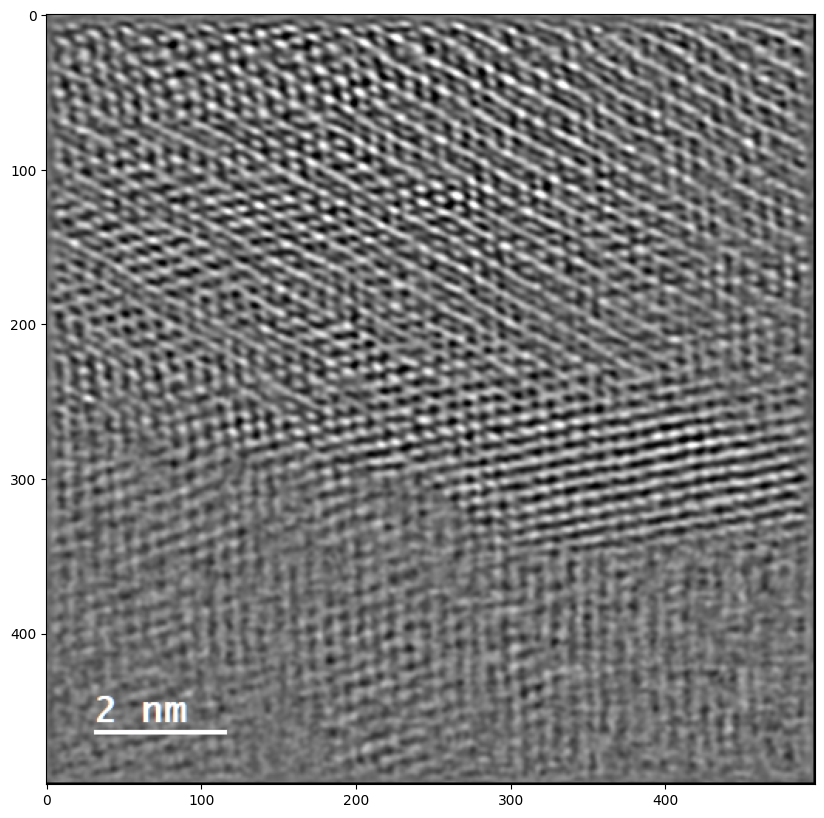

In [51]:
plt.figure(figsize=(10,10))
plt.imshow(image)
#plt.axis('off')
plt.show()

### Image resampling according to probe position


size of ptycho image (no padding)

In [ ]:
# grab probe position from 'ptycho.scanwindow'


resample STEM-BF image (PNG/BMP)

In [53]:
import numpy as np
from skimage import io, transform
import os

def resample_image(image_path, target_height, target_width, save_path):
    image = io.imread(image_path)

    # Calculate scaling factors
    height_ratio = target_height / image.shape[0]
    width_ratio = target_width / image.shape[1]

    # Resample the image
    resampled_image = transform.resize(image, (target_height, target_width), mode='reflect')

    # Save the resampled image to the selected path
    io.imsave(save_path, (resampled_image * 255).astype(np.uint8))

# Define target dimensions based on probe position of 4D cube
target_height = 512
target_width = 512

# Provide the path to your image file
image_path = '/content/ptycho_integration/STEM_polymer/PEN/PEN_thesis_CH05_02.png'
# Define the selected save directory
save_dir = '/content/'
# Replace 'selected_save_path' with your desired directory.

# Get the original file name (without extension)
original_filename = os.path.splitext(os.path.basename(image_path))[0]

# Create a new filename with pixel size information
new_filename = f'{original_filename}_{target_height}x{target_width}.png'

# Combine the save directory and the new filename
save_path = os.path.join(save_dir, new_filename)

# Resample the image and save to the selected path
resample_image(image_path, target_height, target_width, save_path)


### Load resampled image

In [54]:
image = cv2.imread(save_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [55]:
print("Shape of image:", image.shape)

Shape of image: (512, 512, 3)


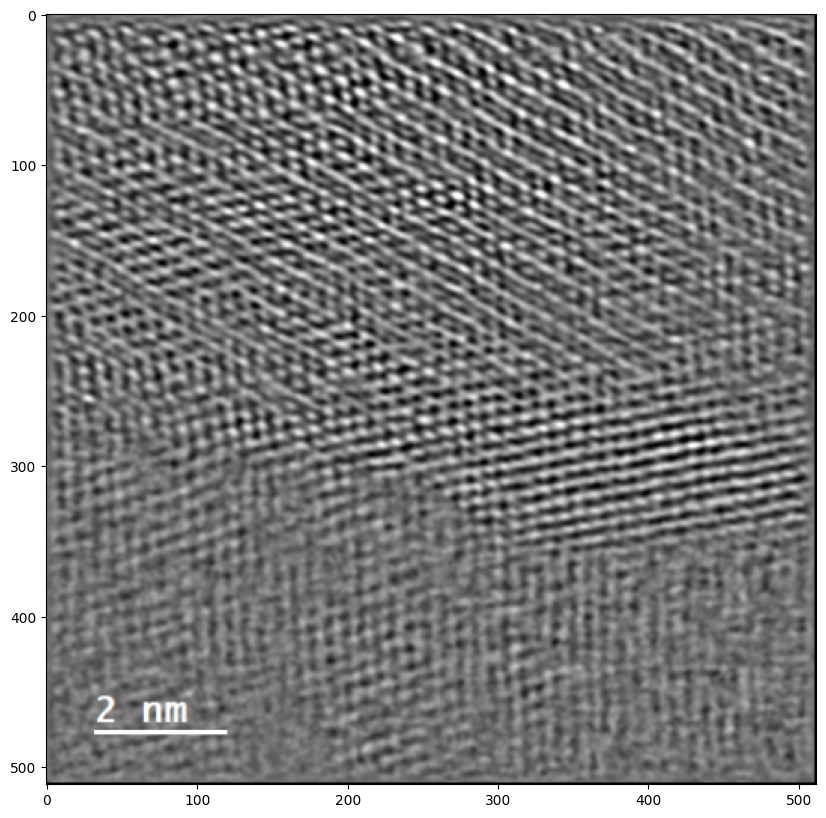

In [56]:
plt.figure(figsize=(10,10))
plt.imshow(image)
#plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [34]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [35]:
masks = mask_generator.generate(image) # generate masks without parameter tuning

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [36]:
print(len(masks))
print(masks[0].keys())

1
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

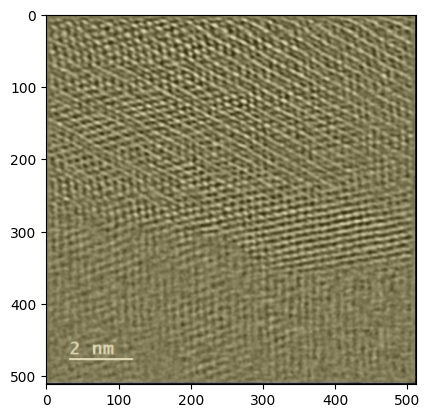

In [61]:
#plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
#plt.axis('off')
plt.show()

## Automatic mask generation with tuning parameter

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [57]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [58]:
masks2 = mask_generator_2.generate(image)

In [59]:
print(len(masks2))
print(masks2[0].keys()) # check the keys in the list

34
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


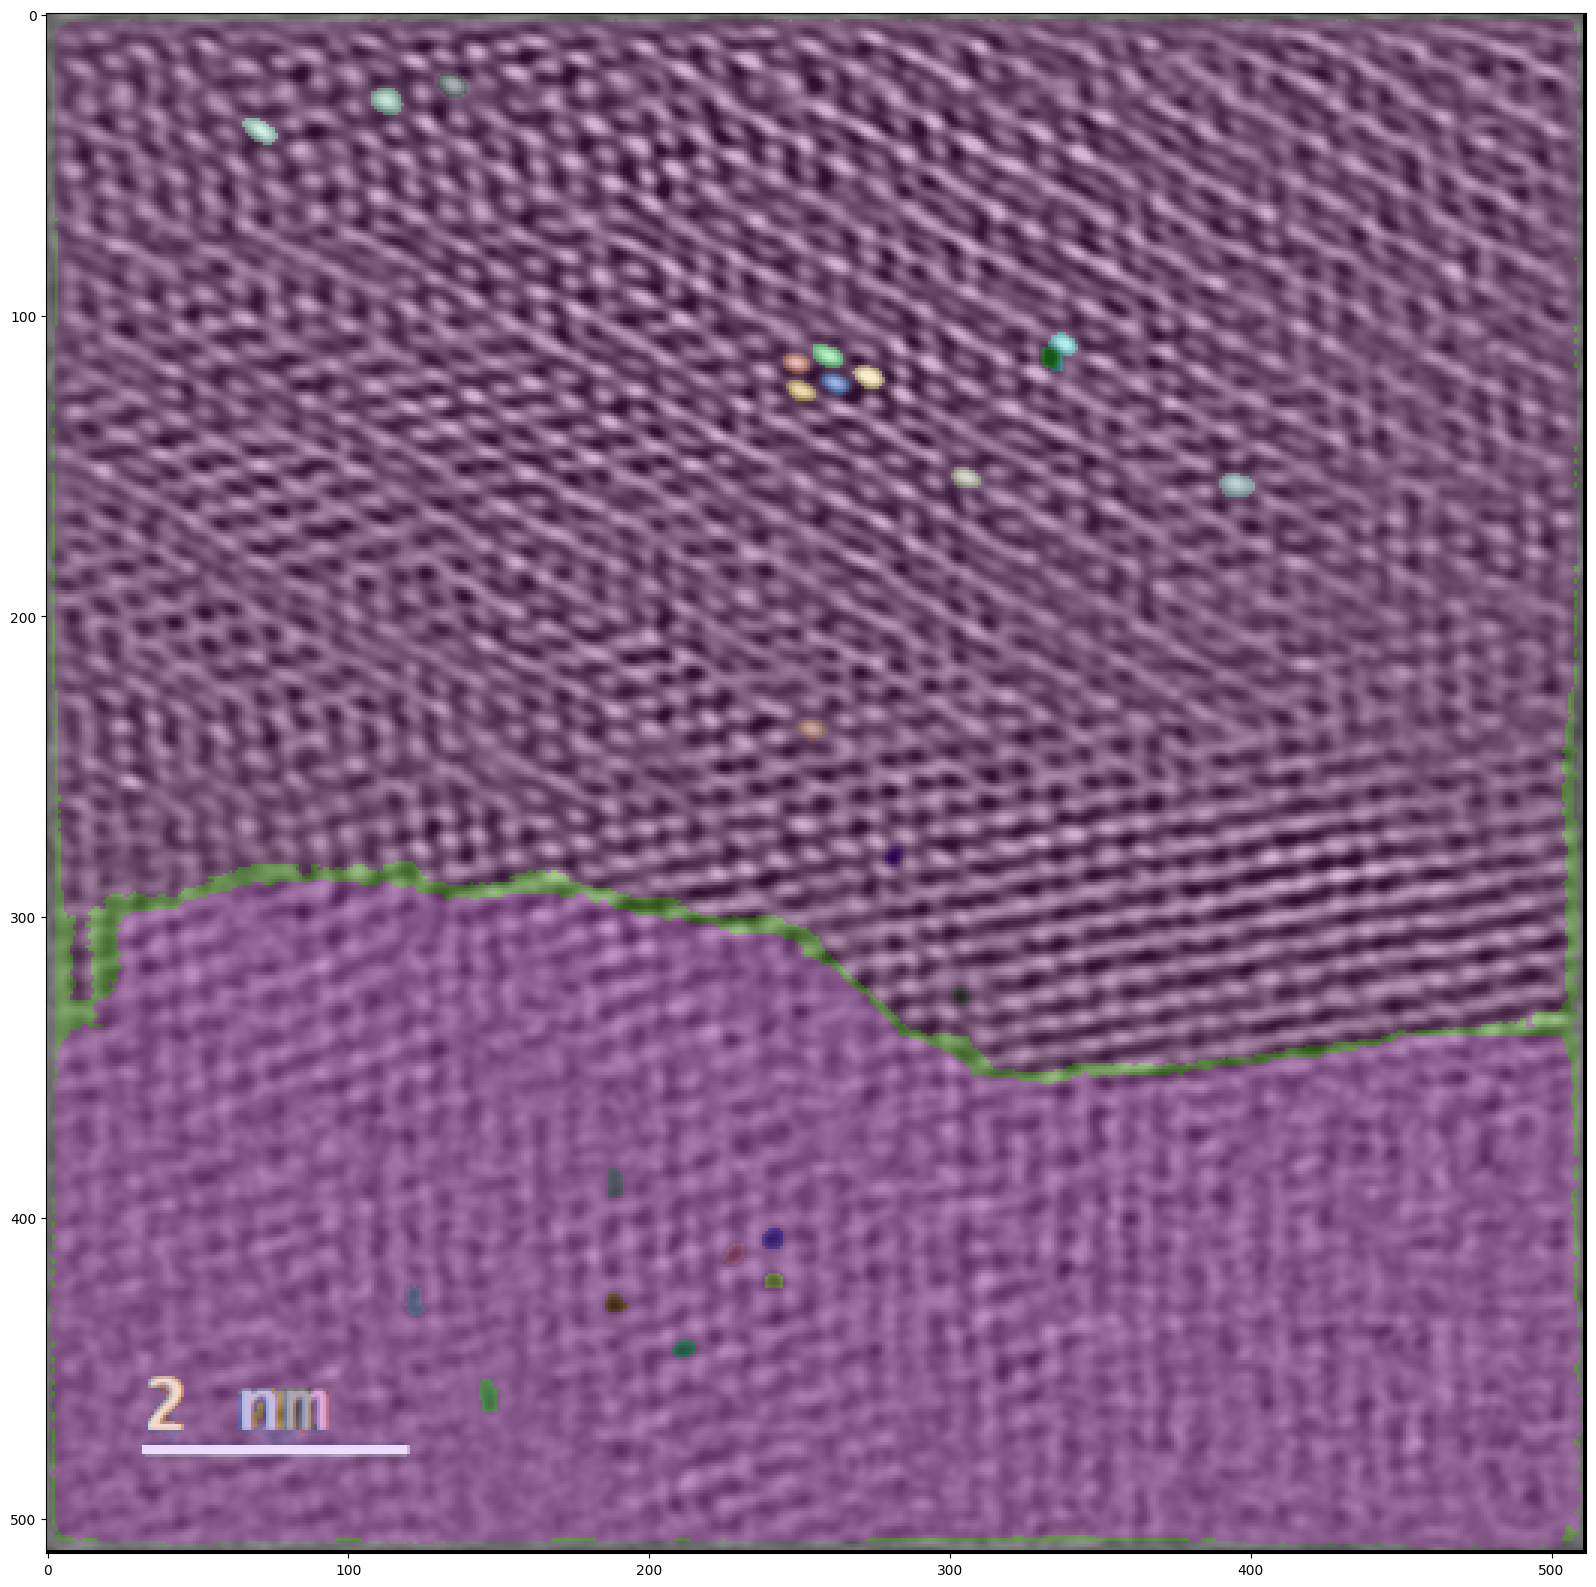

In [60]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
#plt.axis('off')
plt.show()

### Plot all the masks

In [26]:
!pip install -q supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 2.1 MB/s eta 0:00:00


In [ ]:
import supervision as sv

masks = [
    mask['segmentation']
    for mask
    in sorted(masks2, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(5, int(len(masks) / 5)), # number of row, and column = len(masks) / 2
    size=(16, 16)
)

### Labelling all the mask and retrieve coordinates of selected one

In [ ]:
import supervision as sv

masks = [(mask['segmentation'], f'Mask {index + 1}') for index,
         mask in enumerate(sorted(masks2, key=lambda x: x['area'], reverse=True))]

# Function to plot a specific mask with label
def plot_specific_mask(specific_mask, label):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(specific_mask, cmap='gray')
    ax.set_title(label)
    #ax.axis('off')
    plt.show()

    # Retrieve pixel coordinates
    coords = np.transpose(np.nonzero(specific_mask))  # Assuming binary mask, get non-zero coordinates
    return coords


# show total number of masks
#print(len(masks2))

# Print the label of the first mask
#print(masks[0][1])

# Plot all masks
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(16, 16))
for ax, (mask, label) in zip(axes.flat, masks):
    ax.imshow(mask, cmap='gray')
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
#plt.show()

# Plot a specific mask
#plot_specific_mask(*masks[1])  # Index starts from 0

In [ ]:
# Plot a specific mask and retrieve coordinates
selected_coords = plot_specific_mask(*masks[2])  # Index starts from 0

#print("Selected Mask Coordinates:")
#print(selected_coords)

### Check the class of mask (optional)

In [ ]:
def check_mask_type(mask):
    unique_values = np.unique(mask)

    if len(unique_values) == 2 and 0 in unique_values and 1 in unique_values:
        return "Binary Mask"
    else:
        return "Multi-class Mask"


In [ ]:
# identify which is mask in the list by printing the class of mask and label
print(type(masks[1][0]))  # mask
print(type(masks[0][1]))  # label

In [ ]:
mask_type = check_mask_type(masks[1][0])

print(mask_type)


## Crop ROI for reconstruction

### crop ROI from the original image with selected mask

In [ ]:
print(type(image)) # 'original_image' should be a NumPy array

In [ ]:
original_image = image
mask_coordinates = selected_coords

# Crop the original image using the mask coordinates
roi = original_image[min(mask_coordinates[:, 0]):max(mask_coordinates[:, 0]),
                     min(mask_coordinates[:, 1]):max(mask_coordinates[:, 1])]

# Display the cropped region
plt.imshow(roi, cmap='gray')
plt.show()


In [ ]:
# Assuming `selected_coords` is a NumPy array containing the coordinates

# Extract the minimum and maximum coordinates
min_row = np.min(selected_coords[:, 0])
max_row = np.max(selected_coords[:, 0])
min_col = np.min(selected_coords[:, 1])
max_col = np.max(selected_coords[:, 1])

# Print the coordinates
print(f'Minimum Row Coordinate: {min_row}')
print(f'Maximum Row Coordinate: {max_row}')
print(f'Minimum Column Coordinate: {min_col}')
print(f'Maximum Column Coordinate: {max_col}')



In [ ]:
# Assuming min_row, max_row, min_col, and max_col are defined

coordinates_list = [min_row, min_col, max_row, max_col]
print(coordinates_list)


### Visualize ROI over original image to check the range

In [ ]:
import numpy as np

# Assuming 'original_image' is the image and 'roi' is the cropped region

# Create a mask of the same size as the original image
mask_crop = np.zeros_like(original_image)

# Set the region of interest (ROI) in the mask to be white
mask_crop[min(mask_coordinates[:, 0]):max(mask_coordinates[:, 0]),
     min(mask_coordinates[:, 1]):max(mask_coordinates[:, 1])] = [0, 255, 0]  # Green color

# Combine the original image and the masked region
overlay = cv2.addWeighted(original_image, 0.7, mask_crop, 0.3, 0)

# Display the result
plt.imshow(overlay, cmap='gray')
plt.show()


### input ROI into Paramfile


In [ ]:
# change 'ptycho.probe_range' to ROI coordinates
# MATLAB plot y than x
probe_range = [min_col, min_row, max_col, max_row ] # probe_range is specifying a rectangular region that starts at the top-left corner (row 1, column 1) and extends to the bottom-right corner (row 256, column 256).

print(probe_range)

### Run reconstruction in MATLAB codes

Edit in Matlab, run git repo ultimately, processing image store in cloud

In [ ]:
!apt install octave

In [ ]:
# -W : no window system
!octave -W /content/bs.m   # read .m file in specified path in colab